# 인물사진을 만들어보자

0. 공통준비
1. 예제학습
2. 프로젝트
3. 회고

## 0. 공통준비

### 데이터(사진) 준비, 라이브러리/모듈 준비, 경로설정

In [4]:
!pip install jupyterthemes
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

In [5]:
set_nb_theme('onedork')

In [6]:
import os
import glob

In [7]:
!pwd

/aiffel/aiffel/Exploration/portrait


In [8]:
path = '/aiffel/aiffel/Exploration/portrait/'

In [9]:
! mkdir -p /aiffel/aiffel/Exploration/portrait/models
! mkdir -p /aiffel/aiffel/Exploration/portrait/images

In [10]:
os.listdir(path)

['images', 'models', '[E-07]portrait.ipynb', '.ipynb_checkpoints']

In [11]:
import urllib # 웹에서 데이터를 받을 때 사용.
import cv2    # OpenCV로 이미지를 처리할 때 필요.
import numpy as np
from pixellib.semantic import semantic_segmentation # 시멘틱 세그멘테이션 모델을 만들 때 사용.
from matplotlib import pyplot as plt
plt.style.use(['dark_background'])

## 1. 예제학습 : 셸로우 포커스 만들기

1. 셸로우 포커스 개요

### 1.1. 셸로우 포커스 개요

셸로우 포커스란?
> = 한국에서는 주로 아웃포커싱이라고 부른다.
> - 정확한 표현은 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus)
> - 사진 분야에서는 일본어에서 유래된 보케(bokeh)라는 표현도 사용한다.
> - 인물사진(portrait)용 포커스

하나의 카메라로 셸로우 포커스를 만드는 방법
> - 원래 두 개의 렌즈가 할 일을 하나의 렌즈에서 구현해야한다.
> - 이미지 세그멘테이션(image segmentation) 기술을 이용하면<br> 한 이미지에서 배경과 사람을 분리할 수 있다.
> - 분리된 배경을 블러처리 후 다시 합성하면 셸로우 포커스가 적용 된(것 처럼 보이는) 결과물을 얻을 수 있다.

### 1.2. 사진 경로 지정 및 확인

- 스티커 합성 exp를 하면서 느낀 가장 큰 교훈은<br>
다른 무엇도 아닌 *내 사진을 쓰지 말자* 였다.
- 그래서 좋아하는 배우 사진을 사용하기로 마음먹었다.
- 큰 고민 없이 '드라마 \<비밀의 숲>에서 이창준을 연기한 유재명 배우'의 사진으로 정했다.
<br>*개멋있으니까*
- 하지만 작품 속 배우의 단독 컷에는 대부분 이미 아웃포커싱이 들어가있었다(..)
- 이왕 결정했다는 이유로, 한---참의 시간을 낭비했다.
> 다음 번에는 작중 인물은 하지말자는 새로운 교훈을 얻었다.

In [12]:
# 작업 중인 경로 외에 이미지파일 경로와 아직 정체모를 모델 경로도 변수지정
img_dir = '/aiffel/aiffel/Exploration/portrait/images/'
model_dir = '/aiffel/aiffel/Exploration/portrait/models/'

(576, 1024, 3)


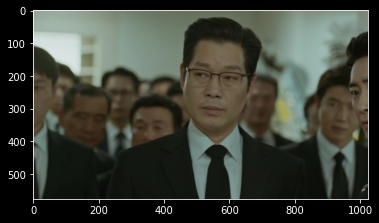

In [13]:
# 원본 이미지 파일도 저장.
img_path = img_dir + 'knight.png'

img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


### 1.3. 인물 분리 : 시맨틱 세그멘테이션을 사용
: 세그멘테이션으로 인물을 분리하자. 전문용어로 '누끼 따기'라고 한단다.




- 세그멘테이션이란?
> 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.


- 시멘틱 세그멘테이션?
> 세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다. 오늘 다룰 세그멘테이션 방법이기도 하죠.


- 인스턴스 세그멘테이션?
> 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.


- 나는 큰일 나버린 것인가?
    : 힘들게 선정한 사진의 배경이 대부분 다른 인물들로 채워져있어 걱정이 앞선다. 일단 진행.
    
    
- 이미지 처리가 그다지 관심 분야도 아니기 때문에 '워터쉐드 세그멘테이션'은 pass

### DeepLab 세그멘테이션 모델을 사용
: 성능이 좋대요.

In [14]:
# 저장할 파일 이름을 결정합니다
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/Exploration/portrait/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f9a741727f0>)

In [15]:
# 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [16]:
#모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

### 모델의 작동원리
- 함수명의 PASCAL VOC는, 학습된 모델의 라벨링 사전이다.
- 어떤 데이터를 학습시켰는디 확인하는 것이 중요하다.
- 개별 모델은 확인할 수 있지만 어떤 사진에 어떤 모델이 좋을지는 어떻게 알지?
> 그나저나 진짜 저 사진으로는 안 될 것 같다는 생각이 든다

In [17]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

#이제는 안 될 것이라는 확신이 들었다.

21

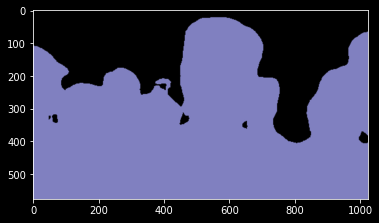

In [18]:
# 끝내주는군.. 다시 찾으러 갑니다.
plt.imshow(output)
plt.show()

(572, 1024, 3)


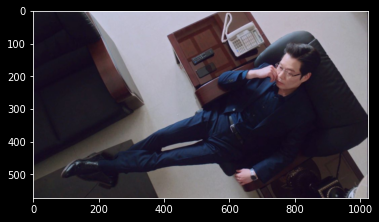

In [19]:
# 처음부터 마음에 들었던 사진이지만 인물과 배경의 거리가 멀면 좋다는 팁에 배제했었던 사진이다.
# TIM : 저 인물의 거의 마지막 장면이자, 또 사진을 바꾸는 일이 없기를 바라는 기원으로 파일명을 정함

img_path = img_dir + 'last.png'

img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# 다시, 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

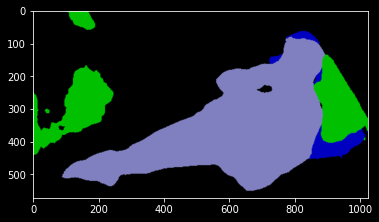

In [21]:
# 좀 심심(?)하지만 훨씬 나아 보인다.
plt.imshow(output)
plt.show()

In [22]:
segvalues

{'class_ids': array([ 0,  9, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
# 이 사진에서 검출된, 사전 학습된, 클래스들은 배경, 의자, 사람, 소파이다. 
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
sofa


In [24]:
# 시키는대로 실행함.
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [25]:
# 사람 라벨의 색상 값. BGR 순서라고 한다.
colormap[15]

array([192, 128, 128])

In [26]:
# RGB로 변경
seg_color = (128,128,192)

(572, 1024)


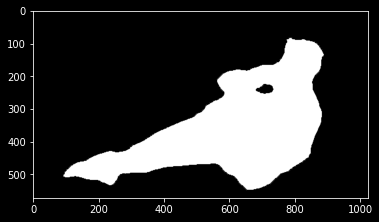

In [27]:
# RGB로 변경된, 사람 라벨, 을 맵핑한다.
# 각 픽셀의 아웃풋이 라벨과 같으면 1(True) 다르면 0(False)으로 맵핑
# 결과적으로 흑백이 된다. 축을 조절해 라벨의 분류에 맞게 프로세스를 진행시키는 듯하다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

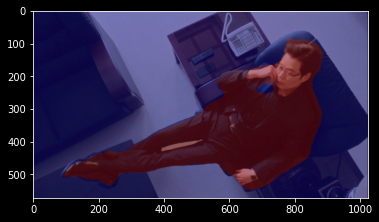

In [28]:
# 원래 이미지와 겹쳐서 확인해보자
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
# 1 -> 255, 0 -> 0
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 1.4. 배경 블러처리
: 이름그대로 blur 메소드를 사용

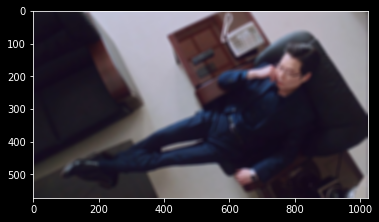

In [29]:
# 원본 사진에 블러 적용
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 코드를 읽어봅시다.

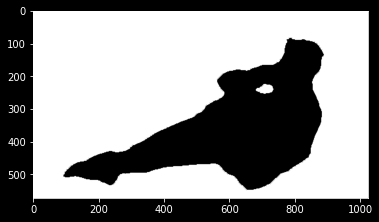

In [30]:
# 이창준은 사람으로 분류되어, 1로 맵핑되었다가, 255로 다시 맵핑되었다.
# 그리고 그레이스케일을 컬러로 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# bitwise_not은 이미지 반전 처리라고 한다.
# 그는 255였다가 반전되어 0 이 되었다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# bitwise_and는 주어진 인자의 비트연산 결과가 모두 참일 경우에만 출력한다고 한다.
# mask영역에 대한 인자가 따로 있지만, 이 실습에서는 마스크 영역 역할을 하는 이미지를 생성한 상태.
# 바로 그 이미지인 img_bg_mask는 다음과같다
plt.imshow(img_bg_mask)
plt.show()

# 이하 코드는 다음 셀에서 출력.

# img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
# plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
# plt.show()

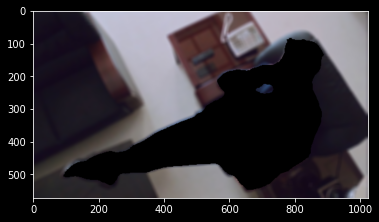

In [31]:
# 위 출력결과에서 확인할 수 있듯, 인간 라벨의 영역은 0인 상태이므로, 결과는 항상 0이다.
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 1.5. 재합성

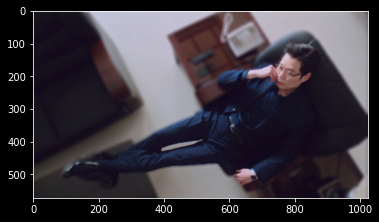

In [32]:
#  np.where(조건, 참일때, 거짓일때)의 형식의 코드 라고한다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 프로젝트

1. 인물모드 사진 제작
2. 제작한 인물모드 사진들이 가지는 문제점 파악
3. 문제에 대한 개선 솔루션 제시


- 아웃포커싱 효과가 적용된 인물사진
>아웃포커싱 적용 인물사진은 사진 선정부터 적용까지 예제와 다른 사진으로 진행했으니 생략하겠음.
- 아웃포커싱 효과가 적용된 고양이 사진
- 배경전환 크로마키 사진




### 2.1. 인물모드 사진 제작

#### (1) 아웃포커싱 효과가 적용된 인물사진
: 아웃포커싱 적용 인물사진은 사진 선정부터 적용까지 예제와 다른 사진으로 진행했으니 생략하겠음.

#### (2) 아웃포커싱 효과가 적용된 고양이 사진

(898, 660, 3)


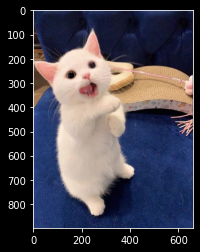

In [33]:
#고양이 사진 경로 저장, 확인
img_path = img_dir + 'cat.jpg'

img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


앞서 모델을 생성해 두었다.

    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

In [34]:
# 변수 새로 지정
segvalues, output = model.segmentAsPascalvoc(img_path)

시멘틱 세그맨테이션의 라벨에는 고양이도 있었는데.. 바로 확인해보자.

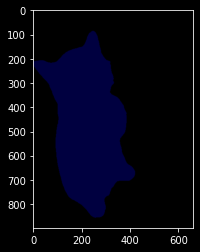

In [35]:
plt.imshow(output)
plt.show()

In [36]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [37]:
# 실제로 별다른 피사체가 없고, 결과 역시 고양이만 분류해내었다.
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


색상 코드를 확인해보자

In [38]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [39]:
# 고양이 영역에 대한 색상 표시는
colormap[8]

array([64,  0,  0])

In [40]:
# BGR to RGB
seg_color = (0,0,64)

(898, 660)


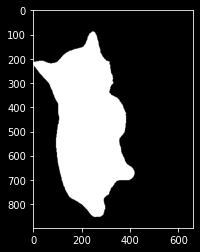

In [83]:
# 고양이가 있는 부분은 1 아니면 0
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

앞서 사람 사진의 경우와 동일한 코드를 사용하면 될 것. 지정해 둔 변수를 보면.

- img_mask = seg_map.astype(np.uint8) * 255
> 255, 0 으로 스케일링

- img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
> 그레이스케일에서 컬러로 컨버트

- img_bg_mask = cv2.bitwise_not(img_mask_color)
> mask 영역을 만든다. bitwise_not 메소드로 반전처리

In [84]:
img_mask = seg_map.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

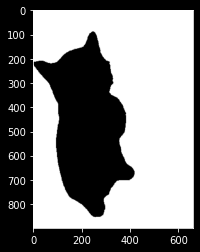

In [51]:
plt.imshow(img_bg_mask)
plt.show()

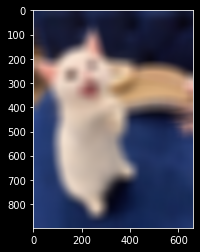

In [52]:
# 블러처리. 어차피 배경이 심플하니 조금 더 큰 숫자를 넣어보자..
img_orig_blur = cv2.blur(img_orig, (50,50))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

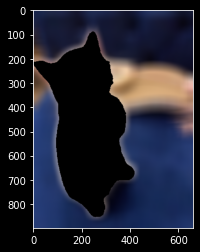

In [53]:
# 배경만 추출
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

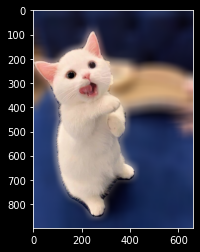

In [54]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### (3) 크로마키 합성을 해보자

- 모델은 물론 위의 귀여운 고양이를 그대로 사용할 것.
- 적절한 배경을 선정해보자

(485, 727, 3)


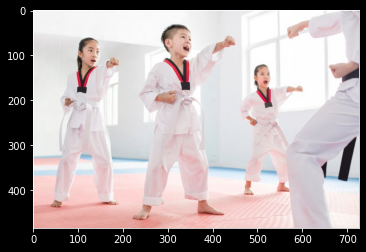

In [55]:
bg_path = img_dir + 'bg.jpg'

bg_orig = cv2.imread(bg_path)

print(bg_orig.shape)
plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

배경은 아주 적절(?)하지만 크기가 조금 작은 것 같다.

(1940, 2908, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

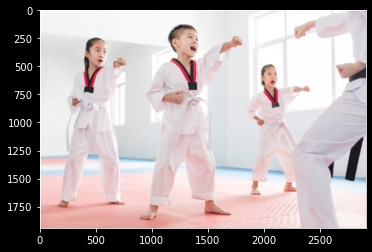

In [193]:
height, width = bg_orig.shape[:2]
bg = cv2.resize(bg_orig, (4*width, 4*height), interpolation = cv2.INTER_LINEAR )
print(bg.shape)
plt.imshow(cv2.cvtColor(bg, cv2.COLOR_BGR2RGB))
plt.show

In [57]:
# 이미지 크기가 다르니 제대로 동작 할지 모르겠다.
# 우선 확인해보자.
# 앞서 만들어둔 img_bg_mask를 그대로 활용.

img_on_bg = cv2.bitwise_and(bg_enlarge, img_bg_mask)
plt.imshow(cv2.cvtColor(img_on_bg, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:212: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


대충 봐도 이미지 사이즈가 맞지 않는다는 내용의 에러가 발생했다.
- openCV의 비트 연산을 사용하기 위해서는, 기본적으로, 이미지의 크기가 같아야 한다고 함.

#### 목적은 임의의 배경을 크로마키 처럼 사용하는 것
즉, 단순히 이미지를 합치는 것이 아니라, 원하는 위치에 고양이가 있으면 나머지가 배경화(?)되는 것

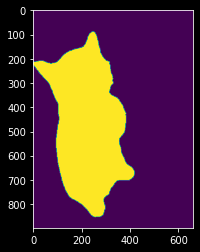

In [85]:
plt.imshow(img_mask)
plt.show()

#### 작전(?)
- 고양이 영역은 0 나머지는 255이다.
- 임의의 배경 영역과 동일한 크기로 확장하되 배열을 255로 채우면 배경과 같은 사이즈를 만들 수 있을 것.
- 원하는 위치에 mask가 위치할 수 있도록 설계(?)되어야 함

좌표 설정을 쉽게 하려면 먼저 mask 이미지의 여백(사실은 255) 부분을 최소화 하는 것이 좋지 않을까?
- 위의 그림을 참고하면 눈대중으로 대략적 좌표를 파악할 수 있다.
- 넘파이 메소드를 활용해 정확한 배열의 인덱스를 찾아보자

In [119]:
print(img_mask.shape)

(898, 660)


In [118]:
print(np.where(np.isin(img_mask[:100], 255) == True))

(array([88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91,
       91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92,
       92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93,
       93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
       94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95,
       95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96,
       96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
       96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97,
       97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98,
       98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98,
       98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
       99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]), array([244, 245, 246, 247,

In [125]:
print(np.where(np.isin(img_mask[850:], 255) == True))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]), array([250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 255, 256, 257, 258]))


In [131]:
print(np.where(np.isin(img_mask[:, 415:], 255) == True))

(array([656, 659, 660, 660, 661, 661, 662, 662, 663, 663, 663, 663, 664,
       664, 664, 664, 665, 665, 665, 665, 666, 666, 666, 666, 667, 667,
       667, 667, 668, 668, 668, 668, 669, 669, 669, 669, 670, 670, 670,
       670, 671, 671, 671, 671, 672, 672, 672, 672, 673, 673, 673, 673,
       674, 674, 674, 674, 675, 675, 675, 675, 676, 676, 676, 676, 677,
       677, 677, 677, 678, 678, 679, 679, 680, 680, 681, 681, 682, 682,
       683]), array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
       0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]))


상단 \~88, 하단 852\~, 우측 418~ 만큼 잘라내자

(765, 419, 3)


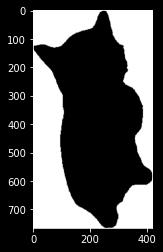

In [133]:
mask_crop = img_bg_mask[88:853, :419]
print(mask_crop.shape)
plt.imshow(mask_crop)
plt.show()

In [134]:
mask_crop[0,0,:]

array([255, 255, 255], dtype=uint8)

다시 반전시켜보자

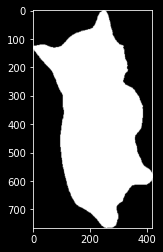

In [161]:
mask_crop = cv2.bitwise_not(mask_crop)
plt.imshow(mask_crop)
plt.show()

#### 다시 작전
0. 먼저 원본의 고양이를 잘라내어오자.
1. 배경과 같은 모양의 배열을 만들고 값들을 0으로 채운다
2. 위 이미지가 배경 크기를 초과하지 않는 선에서 랜덤으로 시작 좌표를 지정한다.
3. 배경용 배열에 위의 이미지 배열을 더해주면 원하는 mask이미지가 생성될 것 같다.

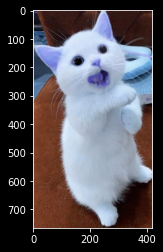

In [137]:
# 원본 이미지를 동일한 크기로 잘라낸다.
img_crop = img_orig[88:853, :419]
plt.imshow(img_crop)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

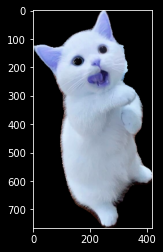

In [140]:
# 고양이만 쏙
cat = cv2.bitwise_and(img_crop, mask_crop)
plt.imshow(cat)
plt.show

In [141]:
bg_enlarge.shape

(1940, 2908, 3)

In [153]:
# 마스킹을 위한 zeros배열 생성
mask_base = np.zeros(1940, 2908, 3)

In [268]:
import random as rd

# 랜덤 시작 좌표를 생성 및 저장
x = rd.randint(0, 2908-419)
y = rd.randint(0, 1940-765)
X = x
Y = y

# 카피 메소드를 사용해주지 않으면 이후의 작업들이 원치 않게 서로 영향을 끼친다.
mask = mask_base.copy()
mask[Y:Y+765, X:X+419] = mask_crop

# 마찬가지로 cat_mask 역시 카피 메소드를 통해 생성
cat_mask = mask.copy()
bg_mask = cv2.bitwise_not(mask)

In [269]:
# 크기를 재차 확인해주고
print(cat_mask.shape)
print(bg_mask.shape)

(1940, 2908, 3)
(1940, 2908, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

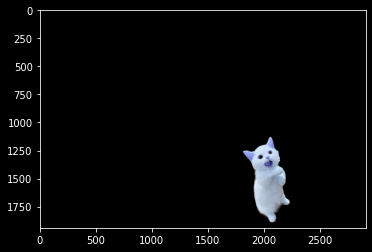

In [278]:
# 배열의 랜덤 영역을 고양이로(!) 채운다.
# rgb 로 컨버트는 마지막에만 진행하자.
cat_mask[Y:Y+765, X:X+419] = cat

plt.imshow(cat_mask)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

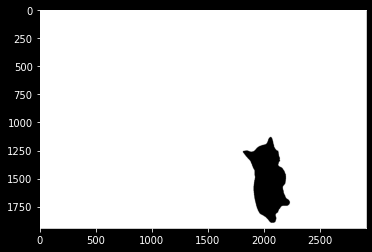

In [271]:
# 앞서 생성한 mask를 반전시킨다.
bg_mask = cv2.bitwise_not(mask).astype(np.uint8)

plt.imshow(bg_mask)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

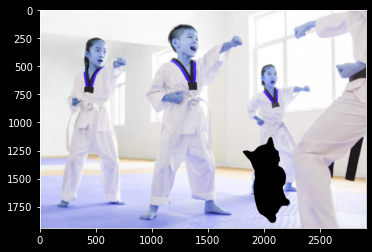

In [274]:
# 배경과 bit연산 해준다. 0인 부분은 그대로 0.
bg_chroma = cv2.bitwise_and(bg, bg_mask)
plt.imshow(bg_chroma)
plt.show

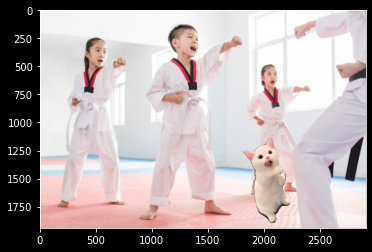

In [285]:
# 해치웠나..?
cat_concat = np.where(cat_mask==0, bg_chroma, cat_mask).astype(np.uint8)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 실습에서 배운대로, bit연산을 활용해 크로마키 배경을 만들어 보았다.
- bit연산이 직관적이기 때문에 활용 자체는 쉬웠다.
- 하지만 대상 이미지의 크기가 같아야하기 때문에 사전작업이 필요했다.
- 그리고 연산을 거칠 때마다 그 결과물도 이진화되기 때문에<br> 배열 타입을 다시 고쳐줘야 한다는 불편이 있었다.

### 2.2. 이 인물모드의 문제점

- 인물모드의 목적은 대상 피사체를 제외한, 배경에 대한 아웃포커싱이다.
- 목적에 대해 DeepLab 모델의 시멘틱 세그멘테이션으로 구현 인물모드는 어떤 점이 미흡한가?


1. 피사체 구분
- 블러 효과를 통해 유사 아웃포커싱을 하기 위해서는 우선 목표 피사체(인물 등)를 구분해야 한다.
- 여기서 구현한 인물모드의 경우 사전에 분류된 라벨에 의존한다.
- 실습에서 제시한, 의자에 걸린 옷이 인물로 분류된 상황은, 세그멘테이션의 정확도가 라벨 학습의 정확도에 종속되는 예시이다.
- 동일한 라벨이 배경에 있다면 아웃포커싱을 적용하기 곤란하다.
> 앞서 처음 사용하려고 했던 사진이 그 예시.

<function matplotlib.pyplot.show(close=None, block=None)>

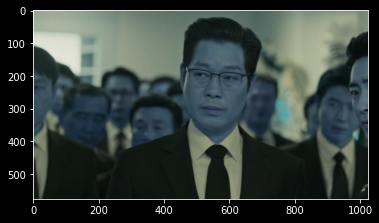

In [286]:
# 아래 사진의 경우 초점 상 대상 피사체인 인물이 명확하지만, 배경 역시 인물들로 채워져 있다.
plt.imshow(cv2.imread(img_dir + 'knight.png'))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

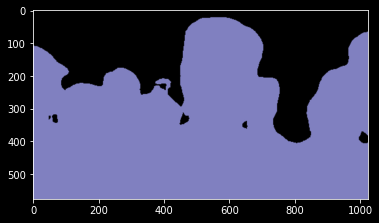

In [288]:
# 결과적으로 피사체의 거리와 무관하게 모두 주 대상이 된다.
segvalues, output = model.segmentAsPascalvoc(img_dir + 'knight.png')
plt.imshow(output)
plt.show

2. 경계의 구분이 정확하지 못하다.

    : 1. 의 문제가 없는 경우, 즉 라벨링 된 대상만을 구분한 경우에도, 그 경계가 명확하지 못하다.
    <br>아래와 같이 마스크 영역에, 대상의 원본 이미지를 넣어보면 문제점이 뚜렷하게 보인다.

<function matplotlib.pyplot.show(close=None, block=None)>

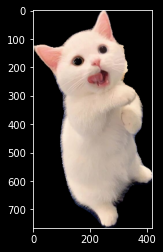

In [289]:
# 냥이의 오른쪽 뺨 부분이 두드러지게 어색하다.
cat = cv2.bitwise_and(img_crop, mask_crop)
plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
plt.show

- 물론, 반대로, 목표 피사체가 배경 등 다른 라벨로 분류되어 잘려나가는 경우도 발생할 수 있다.

### 2.3. 솔루션

- 목표 설정 문제
    - 정확한 피사계 심도 구분 기능을 구현하고자 한다면 사전 학습된 라벨 데이터를 이용한 분류는 애초에 틀린 접근이다.
    - 크로마키를 만들어 보는 과정에서 이 모듈과, 근본 아이디어의 유용성은 달리 많다고 생각하게 되었다.

- 아웃포커싱을 위한 피사체 구분
    - 고전적인(?) 방식으로 이미지의 변화 양상을 통해 피사체를 구분하는 것이 더 좋지 않을까?
    - 또한 아웃포커싱은 기본적으로 피사체를 출력 화면 중앙에 둔다는 것을 활용 할 수 있을 것 같다.